Import Libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

Loading Dataset

In [42]:
dataset = pd.read_csv('Facebook_Marketplace_data.csv')
df = pd.DataFrame(dataset)
df_clean = df.drop(columns=['Column1', 'Column2', 'Column3', 'Column4'])
df_clean['status_published'] = pd.to_datetime(df_clean['status_published'])
print("The given Facebook Marketplace Dataset: ")
print(df_clean)

The given Facebook Marketplace Dataset: 
      status_id status_type    status_published  num_reactions  num_comments  \
0             1       video 2018-04-22 06:00:00            529           512   
1             2       photo 2018-04-21 22:45:00            150             0   
2             3       video 2018-04-21 06:17:00            227           236   
3             4       photo 2018-04-21 02:29:00            111             0   
4             5       photo 2018-04-18 03:22:00            213             0   
...         ...         ...                 ...            ...           ...   
7045       7046       photo 2016-09-24 02:58:00             89             0   
7046       7047       photo 2016-09-23 11:19:00             16             0   
7047       7048       photo 2016-09-21 23:03:00              2             0   
7048       7049       photo 2016-09-20 00:43:00            351            12   
7049       7050       photo 2016-09-10 10:30:00             17             0   

Q1: How does time of upload affect num_reactions, Q2: Correlation between num_reactions, num_comments, num_shares

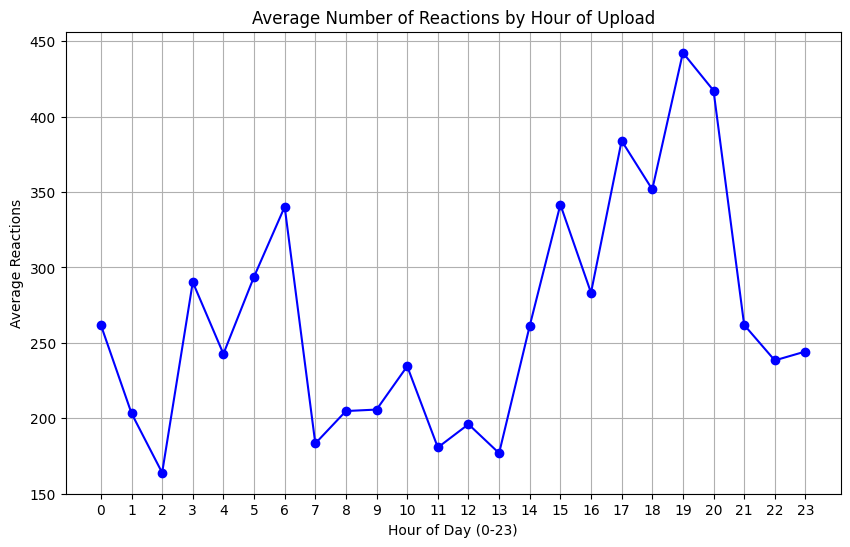


Correlation Matrix:
                num_reactions  num_comments  num_shares
num_reactions       1.000000      0.150843    0.250723
num_comments        0.150843      1.000000    0.640637
num_shares          0.250723      0.640637    1.000000


In [43]:
df_clean['hour'] = df_clean['status_published'].dt.hour
hourly_reactions = df_clean.groupby('hour')['num_reactions'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_reactions.index, hourly_reactions.values, marker='o', color='b')
plt.title('Average Number of Reactions by Hour of Upload')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Reactions')
plt.grid(True)
plt.xticks(range(0, 24))
plt.savefig('hourly_reactions_plot.png')
plt.show()

correlation_matrix = df_clean[['num_reactions', 'num_comments', 'num_shares']].corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

Total Types of Posts

In [44]:
unique_posts = df['status_type'].unique()
count_posts = df['status_type'].value_counts()
print("Types of Posts: ")
print(unique_posts)
print("No. of posts: ")
print(count_posts)

Types of Posts: 
['video' 'photo' 'link' 'status']
No. of posts: 
status_type
photo     4288
video     2334
status     365
link        63
Name: count, dtype: int64


Forming X Matrix for KMeans Clustering

In [45]:
X = df.iloc[:, [1,3,4,5,6,7,8,9,10,11]].values
print("Dependent Variable Matrix X: ")
print(X)

Dependent Variable Matrix X: 
[['video' 529 512 ... 1 1 0]
 ['photo' 150 0 ... 0 0 0]
 ['video' 227 236 ... 1 0 0]
 ...
 ['photo' 2 0 ... 0 0 0]
 ['photo' 351 12 ... 0 0 0]
 ['photo' 17 0 ... 0 0 0]]


Dealing with Missing Values

In [46]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X[:, 4:])
X[:, 4:] = imputer.transform(X[:, 4:])
print("Dependent Variable Matrix X after Dealing with Missing Values: ")
print(X)

Dependent Variable Matrix X after Dealing with Missing Values: 
[['video' 529 512 ... 1.0 1.0 0.0]
 ['photo' 150 0 ... 0.0 0.0 0.0]
 ['video' 227 236 ... 1.0 0.0 0.0]
 ...
 ['photo' 2 0 ... 0.0 0.0 0.0]
 ['photo' 351 12 ... 0.0 0.0 0.0]
 ['photo' 17 0 ... 0.0 0.0 0.0]]


Applying OneHotEncoder since status_type field has categorical values

In [47]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
print("Dependent Variable Matrix X after OneHotEncoder: ")
print(X)

Dependent Variable Matrix X after OneHotEncoder: 
[[0.0 0.0 0.0 ... 1.0 1.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 1.0 0.0 0.0]
 ...
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]]


Applying Feature Scaling leaving out Dummy Variables (Photo, Video, Link, Status)

In [48]:
sc = StandardScaler()
X[:, 4:] = sc.fit_transform(X[:, 4:])
print("Dependent Variable Matrix X after Feature Scaling: ")
print(X)

Dependent Variable Matrix X after Feature Scaling: 
[[0.0 0.0 0.0 ... 0.07671305463840127 0.47357035270389564
  -0.15574802701539486]
 [0.0 1.0 0.0 ... -0.17600985900679916 -0.15258699661389585
  -0.15574802701539486]
 [0.0 0.0 0.0 ... 0.07671305463840127 -0.15258699661389585
  -0.15574802701539486]
 ...
 [0.0 1.0 0.0 ... -0.17600985900679916 -0.15258699661389585
  -0.15574802701539486]
 [0.0 1.0 0.0 ... -0.17600985900679916 -0.15258699661389585
  -0.15574802701539486]
 [0.0 1.0 0.0 ... -0.17600985900679916 -0.15258699661389585
  -0.15574802701539486]]


Running KMeans to find Optimal K value

In [49]:
wcss = []
for i in range(1,11): #Usuually, range(1,11) is enough to find optimal K value...
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit_predict(X)
  wcss.append(kmeans.inertia_)
print(wcss)

[67099.75971631073, 51735.87354427543, 41815.41970670725, 35963.910816320546, 31980.799298298876, 29883.532069830242, 26114.810264113003, 22927.644660913324, 21688.086722971526, 19629.00332551138]


Plotting Elbow Graph

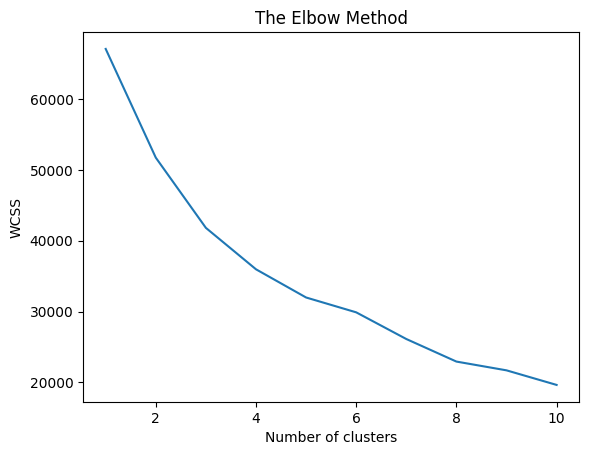

In [50]:
K = range(1,11)
plt.plot(K, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() #Noticeable kink at 3, Optimal K value is 3...

KMeans for Optimal K = 3

In [51]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

Reducing No. of Variables with PCA

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

Plotting Clusters

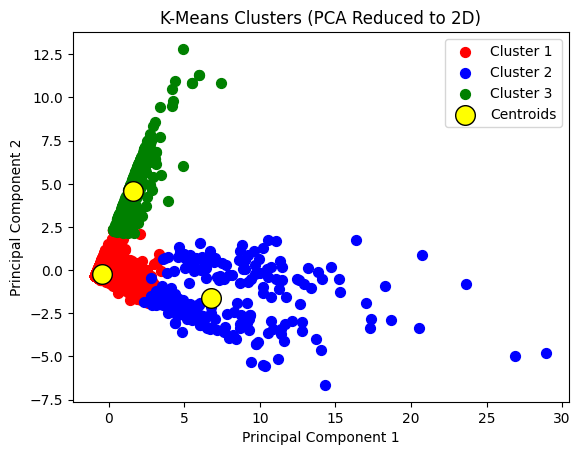

In [53]:
plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1], s=50, c='blue', label='Cluster 2')
plt.scatter(X_pca[y_kmeans == 2, 0], X_pca[y_kmeans == 2, 1], s=50, c='green', label='Cluster 3')
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='yellow', label='Centroids', edgecolor='black')
plt.title('K-Means Clusters (PCA Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Average Value of num_reactions, num_comments and num_shares for each post type

In [54]:
avg_engagement = df.groupby('status_type')[ ['num_reactions','num_comments','num_shares']].mean()
print("Average Value of num_reactions, num_comments and num_shares for each post type: ")
print(avg_engagement)


Average Value of num_reactions, num_comments and num_shares for each post type: 
             num_reactions  num_comments  num_shares
status_type                                         
link            370.142857      5.698413    4.396825
photo           181.290345     15.993470    2.553871
status          438.783562     36.238356    2.558904
video           283.409597    642.478149  115.679949
